In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pandas as pd
import pickle
import yaml
from pathlib import Path

import bacco
import baccoemu

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import data_loader
import plotter
import plot_utils
import utils
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-05-30 18:30:36.466769: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-30 18:30:36.569700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 18:30:36.569740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 18:30:36.582771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 18:30:36.613410: I tensorflow/core/platform/cpu_feature_guar

In [3]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

### Fixed-parameter set to estimate covariance:

In [4]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params_cv = '_quijote_p0_n1000'
tag_biasparams_cv = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params_cv + tag_biasparams_cv + tag_datagen

In [5]:
k_cv, y_cv, y_err_cv, idxs_params, params_df_cv, param_dict_fixed_cv, biasparams_df_cv, biasparams_dict_fixed_cv, random_ints_cosmo_cv, random_ints_bias_cv = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params_cv, tag_biasparams_cv,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k_cv, y_cv, y_err_cv = k_cv[0], y_cv[0], y_err_cv[0]

Loading muchisimocks data
_b1000_p0_n1
Found 1000 pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_quijote_p0_n1000_b1000_p0_n1
dir statistics /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_quijote_p0_n1000_b1000_p0_n1
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins


In [6]:
# this should align with y_cv
param_names_cv = data_loader.get_param_names(tag_params=tag_params_cv, tag_biasparams=tag_biasparams_cv)

In [7]:
params_dict_cv = param_dict_fixed_cv.copy()
params_dict_cv.update(biasparams_dict_fixed_cv)
print(params_dict_cv)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [8]:
cov_fid = np.cov(y_cv, rowvar=False)
print(cov_fid.shape)

(29, 29)


In [9]:
theta_fid = [params_dict_cv[param] for param in utils.param_names_all_ordered]

## Load in fisher muchisimocks set - cosmo only

In [10]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_fisher_quijote'
tag_biasparams = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen

In [12]:
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, random_ints_cosmo, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

Loading muchisimocks data
_b1000_p0_n1
Found 21 pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
dir statistics /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
Loaded pk data with shape (21, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_b1000_p0_n1.txt (already exists)
Masked 1 out of 30 bins
(21, 29)
(29,)


### Compute derivatives

In [13]:
def compute_derivatives_from_fisherset(params_df, pk_array, param_names,
                                       n_deltas_for_diff=1):
    """
    Compute derivatives of the power spectra using finite differences from the _fisher_quijote set.
    Assumes params_df has columns 'changed_param' and 'n_delta', and pk_array is aligned row-wise.
    Uses n_delta = n_deltas_for_diff and n_delta = -n_deltas_for_diff for each parameter.

    Returns:
        derivatives: dict of {param_name: derivative array (same shape as pk)}
    """
    derivatives = {}
    for param in param_names:
        # Find indices for n_delta = n_deltas_for_dif and n_delta = -n_deltas_for_diff for this parameter
        idx_plus = params_df[(params_df['param_shifted'] == param) & (params_df['n_deltas'] == n_deltas_for_diff)].index
        idx_minus = params_df[(params_df['param_shifted'] == param) & (params_df['n_deltas'] == -n_deltas_for_diff)].index
        if len(idx_plus) == 0 or len(idx_minus) == 0:
            raise ValueError(f"Missing n_delta=2 or n_delta=-2 for parameter {param}")
        pk_plus = pk_array[idx_plus[0]]
        pk_minus = pk_array[idx_minus[0]]
        delta_tot = params_df.loc[idx_plus[0], param] - params_df.loc[idx_minus[0], param]
        derivatives[param] = (pk_plus - pk_minus) / delta_tot
    return derivatives

In [14]:
derivatives_shift_nd1 = compute_derivatives_from_fisherset(params_df, y, 
                        utils.cosmo_param_names_ordered, n_deltas_for_diff=1)

In [15]:
derivatives_shift_nd2 = compute_derivatives_from_fisherset(params_df, y, 
                        utils.cosmo_param_names_ordered, n_deltas_for_diff=2)

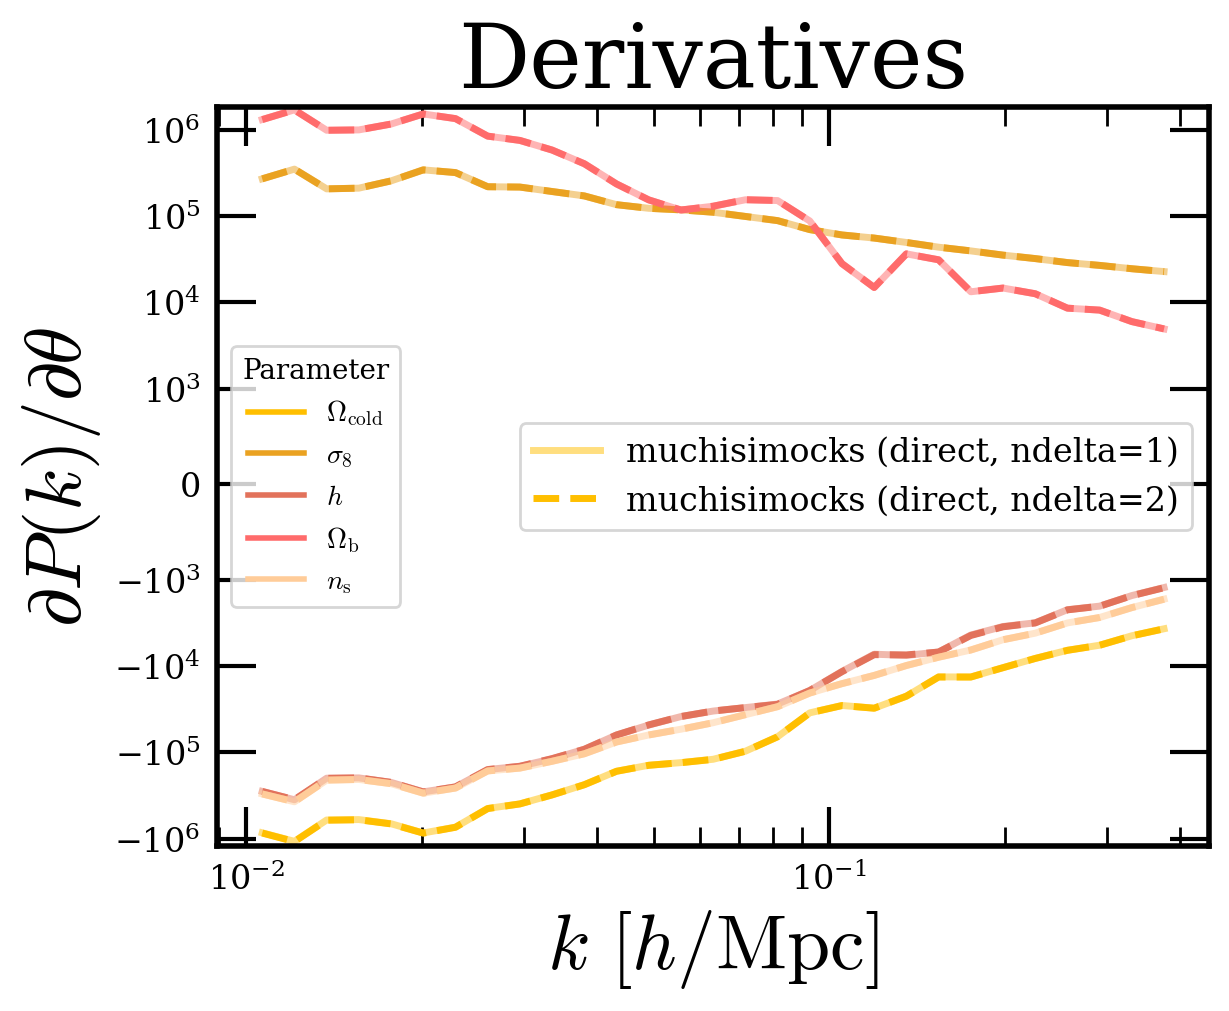

In [16]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.cosmo_param_names_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(k, derivatives_shift_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k, derivatives_shift_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

### Compute fisher matrices

In [17]:
fisher_matrix_shift_nd1 = utils.compute_fisher_matrix(derivatives_shift_nd1, cov_fid, param_names_show)
cov_fisher_shift_nd1 = np.linalg.inv(fisher_matrix_shift_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_nd1.shape)

Fisher matrix shape: (5, 5)


In [18]:
fisher_matrix_shift_nd2 = utils.compute_fisher_matrix(derivatives_shift_nd2, cov_fid, param_names_show)
cov_fisher_shift_nd2 = np.linalg.inv(fisher_matrix_shift_nd2)
print("Fisher matrix shape:", fisher_matrix_shift_nd2.shape)

Fisher matrix shape: (5, 5)


In [19]:
n_samples = 10000
samples_shift_nd1 = np.random.multivariate_normal(theta_fid[:len(param_names_show)], cov_fisher_shift_nd1, size=n_samples)

In [20]:
n_samples = 10000
samples_shift_nd2 = np.random.multivariate_normal(theta_fid[:len(param_names_show)], cov_fisher_shift_nd2, size=n_samples)

In [21]:
params_dict = params_df.iloc[0].to_dict()
params_dict.pop('param_shifted')
params_dict.pop('n_deltas')
#params_dict_cv.update(biasparams_dict_fixed_cv)
#print(params_dict_cv)

0

In [22]:
# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo('_p5_n10000')
_, dict_bounds_bias, _ = genp.define_LH_bias('_biaszen_p4_n10000')
extents = {**dict_bounds_cosmo, **dict_bounds_bias}
print(extents)

{'omega_cold': [0.23, 0.4], 'omega_baryon': [0.04, 0.06], 'sigma8_cold': [0.65, 0.9], 'ns': [0.92, 1.01], 'hubble': [0.6, 0.8], 'neutrino_mass': [0.0, 0.4], 'w0': [-1.15, -0.85], 'wa': [-0.3, 0.3], 'b1': [-1.0, 2.0], 'b2': [-2.0, 2.0], 'bs2': [-2.0, 2.0], 'bl': [-10.0, 10.0]}


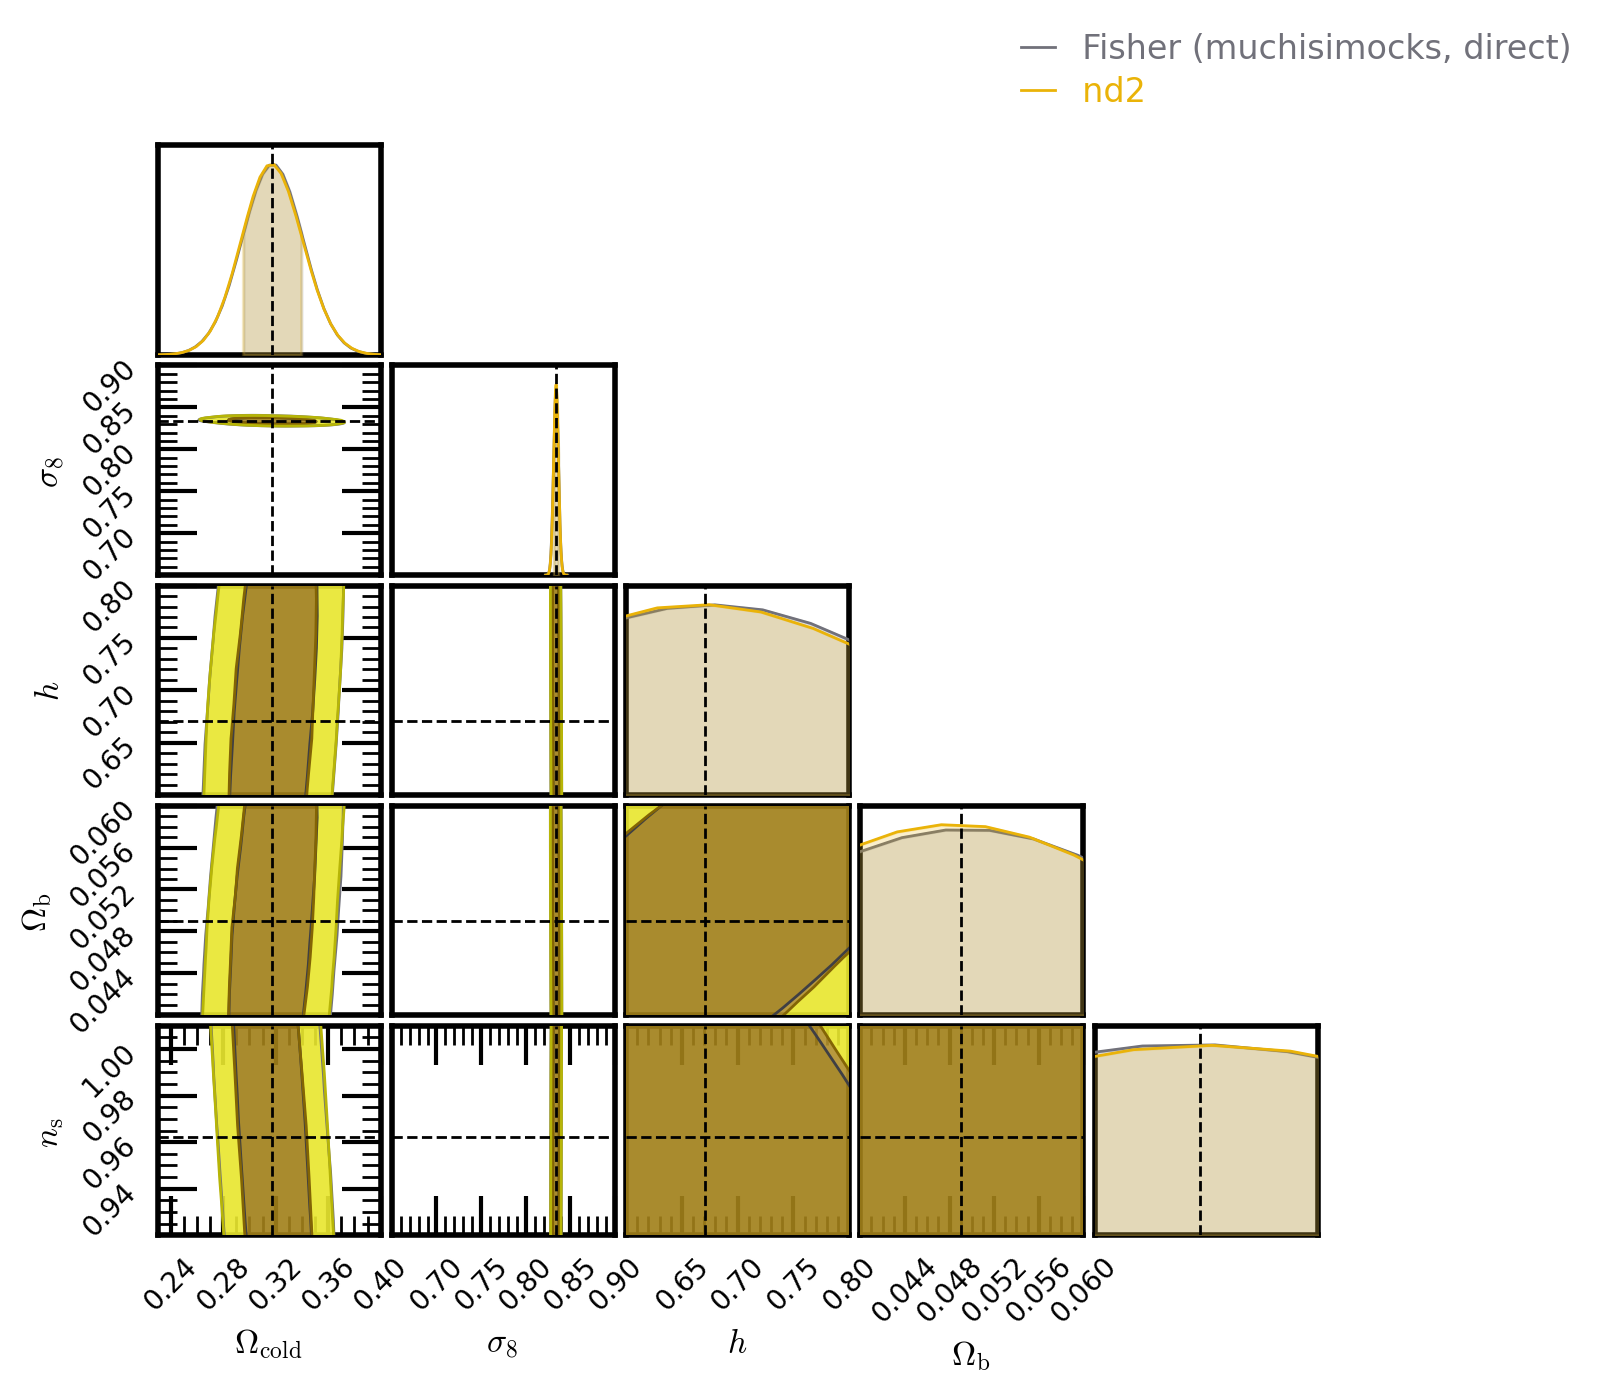

In [23]:

samples_arr = [samples_shift_nd1, samples_shift_nd2]
labels = ['Fisher (muchisimocks, direct)', 'nd2']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, param_names_show, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

## Fisher set now with free bias params

In [24]:
data_mode = 'muchisimocks'
statistics = ['pk']

tag_params = '_fisher_quijote'
tag_biasparams_biaszen = '_fisher_biaszen'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data_biaszen = '_'+data_mode + tag_stats + tag_params + tag_biasparams_biaszen + tag_datagen

In [25]:
k_biaszen, y_biaszen, y_err_biaszen, idxs_params_biaszen, params_df_biaszen, param_dict_fixed_biaszen, biasparams_df_biaszen, biasparams_dict_fixed_biaszen, random_ints_cosmo_biaszen, random_ints_bias_biaszen = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams_biaszen,
                                    tag_data=tag_data_biaszen,
                                    kwargs=kwargs_data)
k_biaszen, y_biaszen, y_err_biaszen = k_biaszen[0], y_biaszen[0], y_err_biaszen[0]
print(k_biaszen.shape)
print(y_biaszen.shape)

Loading muchisimocks data
_fisher_biaszen
Found 21 pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
dir statistics /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_fisher_quijote
Loaded pk data with shape (37, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_fisher_quijote_fisher_biaszen.txt
Loading from ../data/masks/mask_muchisimocks_pk_fisher_quijote_fisher_biaszen.txt (already exists)
Masked 1 out of 30 bins
(29,)
(37, 29)


In [26]:
def combine_fisher_param_dfs(params_df, biasparams_df):
    """
    Combine cosmological and bias parameter DataFrames for Fisher analysis.
    For every non-fiducial row in params_df, combine with fiducial biasparams_df.
    For every non-fiducial row in biasparams_df, combine with fiducial params_df.
    The fiducial row is where 'param_shifted' == 'fiducial'.
    Adds columns 'idx_cosmo', 'idx_bias', 'param_shifted', and 'n_deltas' for the original indices and meta info.
    Returns a DataFrame where each row is the fiducial with only one parameter varied.
    """
    # Identify fiducial rows
    fiducial_params_row = params_df[params_df['param_shifted'] == 'fiducial'].iloc[0]
    fiducial_bias_row = biasparams_df[biasparams_df['param_shifted'] == 'fiducial'].iloc[0]

    # Get parameter names (excluding meta columns)
    param_cols = [c for c in params_df.columns if c not in ['param_shifted', 'n_deltas']]
    bias_cols = [c for c in biasparams_df.columns if c not in ['param_shifted', 'n_deltas']]

    # Start with the all-fiducial row
    rows = []
    fiducial_row = {**fiducial_params_row[param_cols].to_dict(), **fiducial_bias_row[bias_cols].to_dict()}
    fiducial_row['idx_cosmo'] = fiducial_params_row.name
    fiducial_row['idx_bias'] = fiducial_bias_row.name
    fiducial_row['param_shifted'] = 'fiducial'
    fiducial_row['n_deltas'] = 0
    rows.append(fiducial_row.copy())

    # For every non-fiducial row in params_df, combine with fiducial biasparams
    for idx, row in params_df[params_df['param_shifted'] != 'fiducial'].iterrows():
        combined = {**row[param_cols].to_dict(), **fiducial_bias_row[bias_cols].to_dict()}
        combined['idx_cosmo'] = idx
        combined['idx_bias'] = fiducial_bias_row.name
        combined['param_shifted'] = row['param_shifted']
        combined['n_deltas'] = row['n_deltas']
        rows.append(combined)

    # For every non-fiducial row in biasparams_df, combine with fiducial params
    for idx, row in biasparams_df[biasparams_df['param_shifted'] != 'fiducial'].iterrows():
        combined = {**fiducial_params_row[param_cols].to_dict(), **row[bias_cols].to_dict()}
        combined['idx_cosmo'] = fiducial_params_row.name
        combined['idx_bias'] = idx
        combined['param_shifted'] = row['param_shifted']
        combined['n_deltas'] = row['n_deltas']
        rows.append(combined)

    all_param_names = param_cols + bias_cols + ['idx_cosmo', 'idx_bias', 'param_shifted', 'n_deltas']
    combined_df = pd.DataFrame(rows, columns=all_param_names)
    return combined_df

In [27]:
params_all_df = combine_fisher_param_dfs(params_df_biaszen, biasparams_df_biaszen)
print(len(params_df_biaszen), len(biasparams_df_biaszen), len(params_all_df))

21 17 37


In [28]:
## need to ensure that the ys are aligned with the params

# Convert both to 2D integer arrays
idxs_params_biaszen = np.array(idxs_params_biaszen)
idxs_params_ordered = params_all_df[['idx_cosmo', 'idx_bias']].values

# Find the matching indices for each ordered pair
matching_indices = [np.where((idxs_params_biaszen == row).all(axis=1))[0][0] for row in idxs_params_ordered]
y_biaszen_ordered = y_biaszen[matching_indices]
print(y_biaszen_ordered.shape)

(37, 29)


### Compute derivs

In [90]:
derivatives_shift_biaszen_nd1 = compute_derivatives_from_fisherset(params_all_df, y_biaszen_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=1)

In [91]:
derivatives_shift_biaszen_nd2 = compute_derivatives_from_fisherset(params_all_df, y_biaszen_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=2)

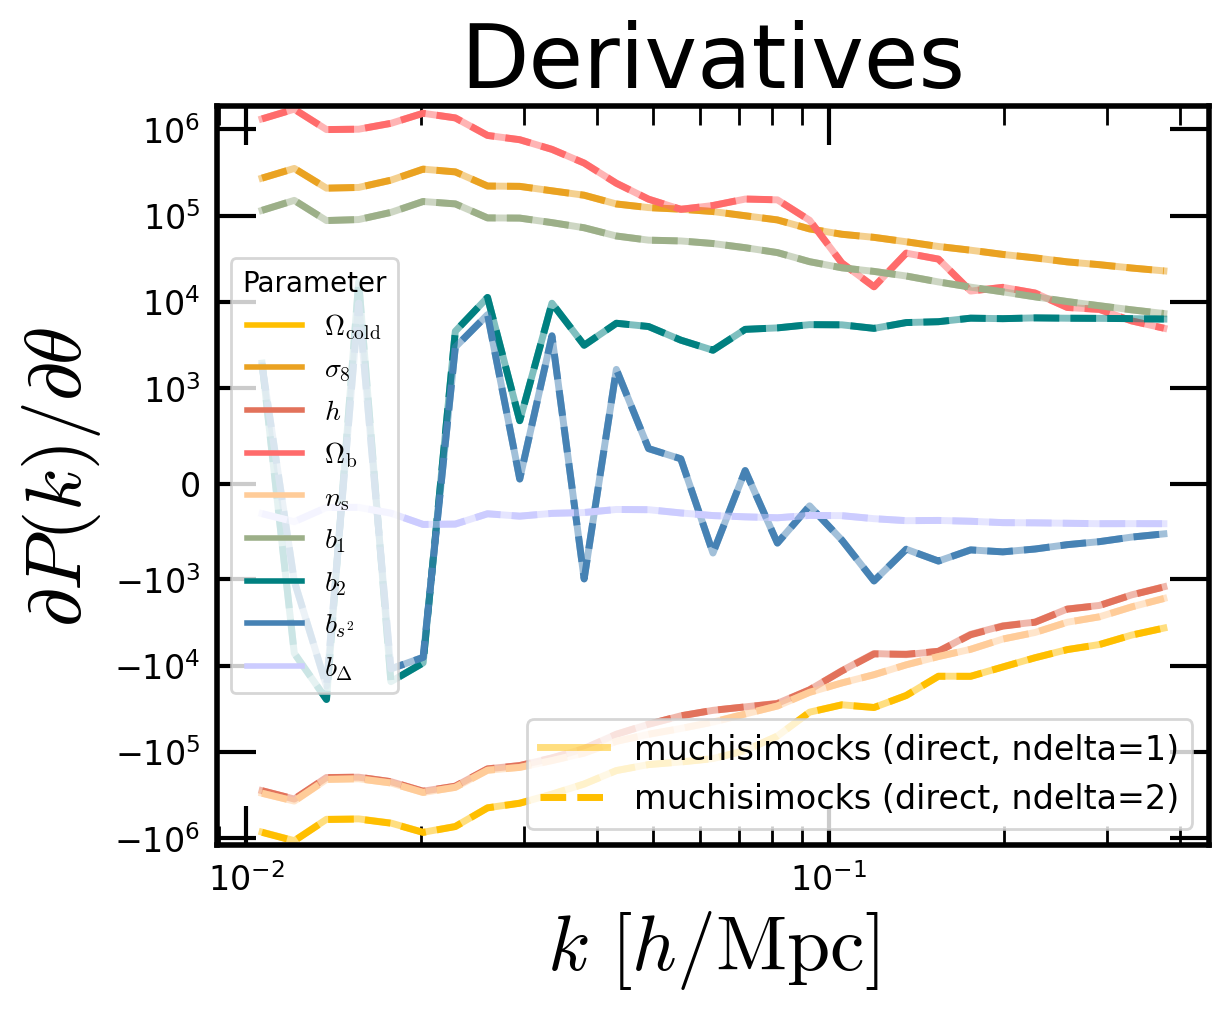

In [92]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(k_biaszen, derivatives_shift_biaszen_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(k_biaszen, derivatives_shift_biaszen_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

### Compute fisher matrices

In [32]:
fisher_matrix_shift_biaszen_nd1 = utils.compute_fisher_matrix(derivatives_shift_biaszen_nd1, cov_fid, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_nd1 = np.linalg.inv(fisher_matrix_shift_biaszen_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_nd1.shape)

Fisher matrix shape: (9, 9)


In [33]:
fisher_matrix_shift_biaszen_nd2 = utils.compute_fisher_matrix(derivatives_shift_biaszen_nd2, cov_fid, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_nd2 = np.linalg.inv(fisher_matrix_shift_biaszen_nd2)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_nd2.shape)

Fisher matrix shape: (9, 9)


In [34]:
n_samples = 10000
samples_shift_biaszen_nd1 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd1, size=n_samples)

In [35]:
n_samples = 10000
samples_shift_biaszen_nd2 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd2, size=n_samples)

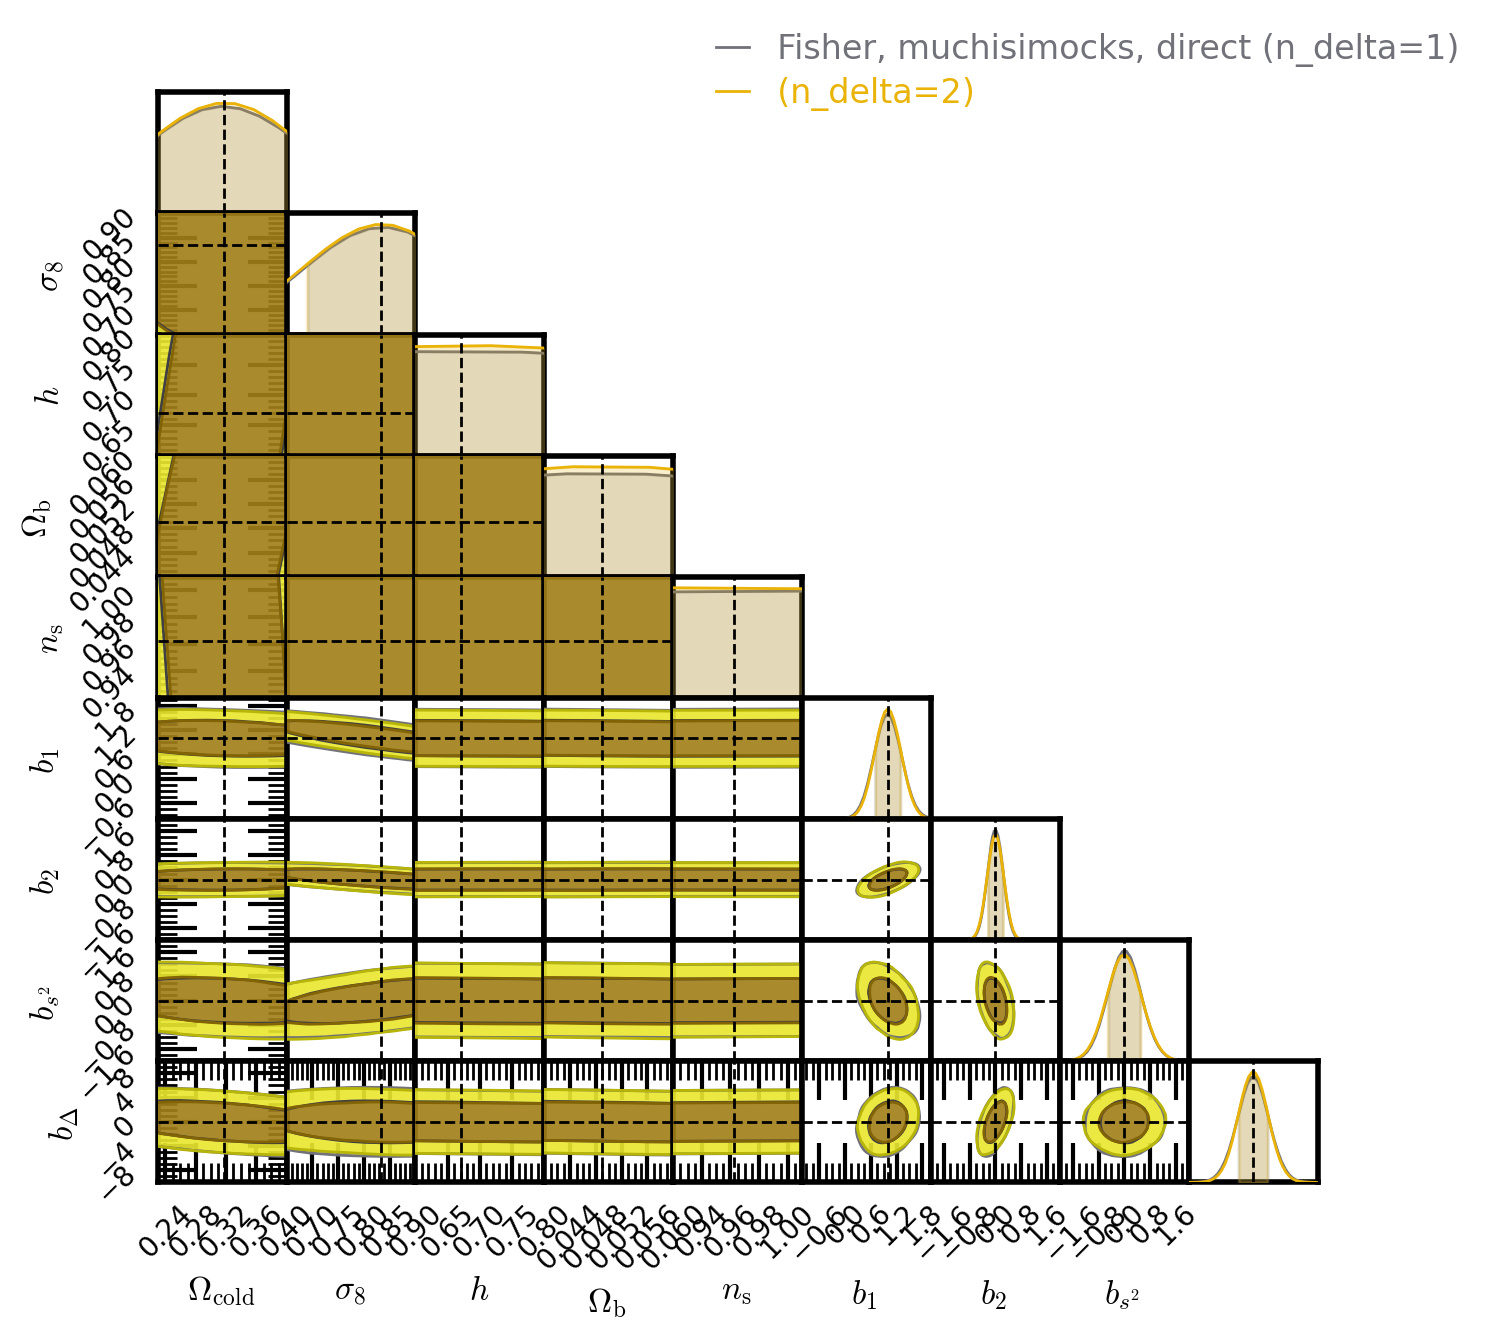

In [36]:

samples_arr = [samples_shift_biaszen_nd1, samples_shift_biaszen_nd2]
labels = ['Fisher, muchisimocks, direct (n_delta=1)', '(n_delta=2)']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

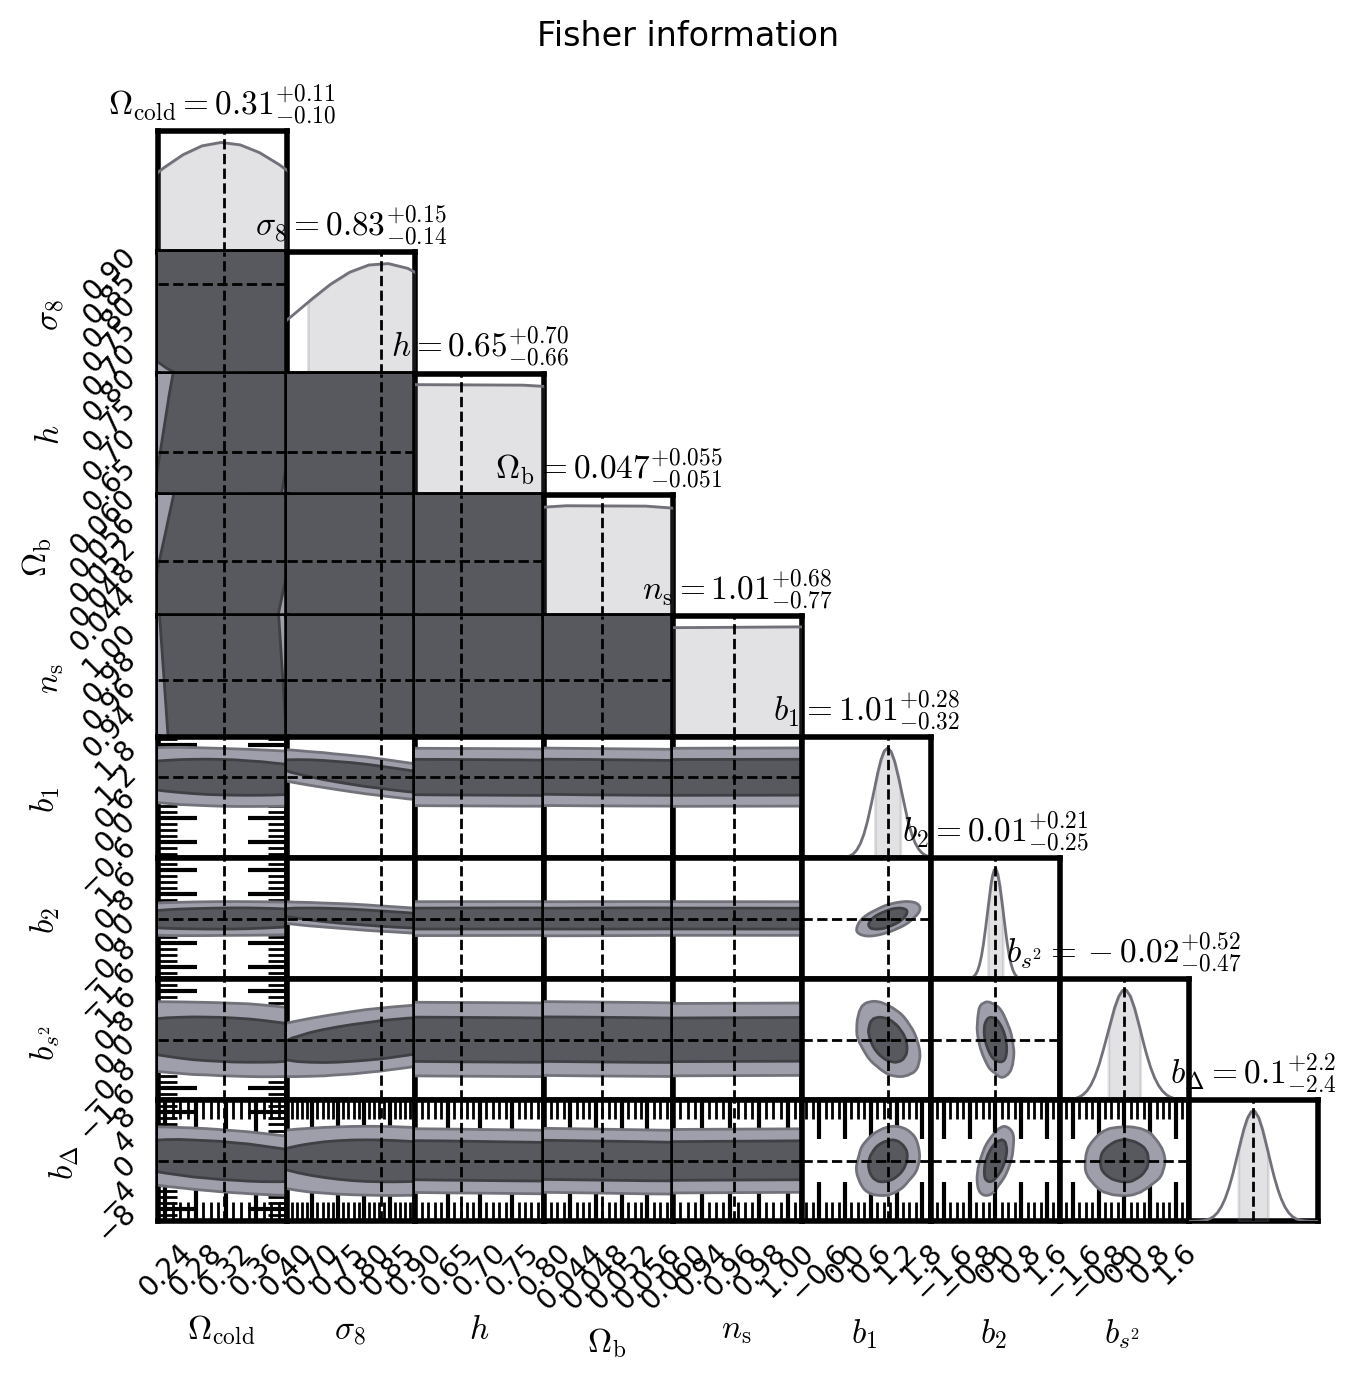

In [37]:

samples_arr = [samples_shift_biaszen_nd1]
labels = ['Fisher, muchisimocks, direct (n_delta=1)', '(n_delta=2)']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title='Fisher information', extents=extents, 
                  figsize=(7,7), fn_save=None)

['_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain10000_best-sbi-rand10']
fn_samples = ../results/results_sbi/sbi_muchisimocksPk_p5_n10000_biaszen_p4_n10000_ntrain10000_best-sbi-rand10/samples_test_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean_pred.npy
(10000, 1, 9)


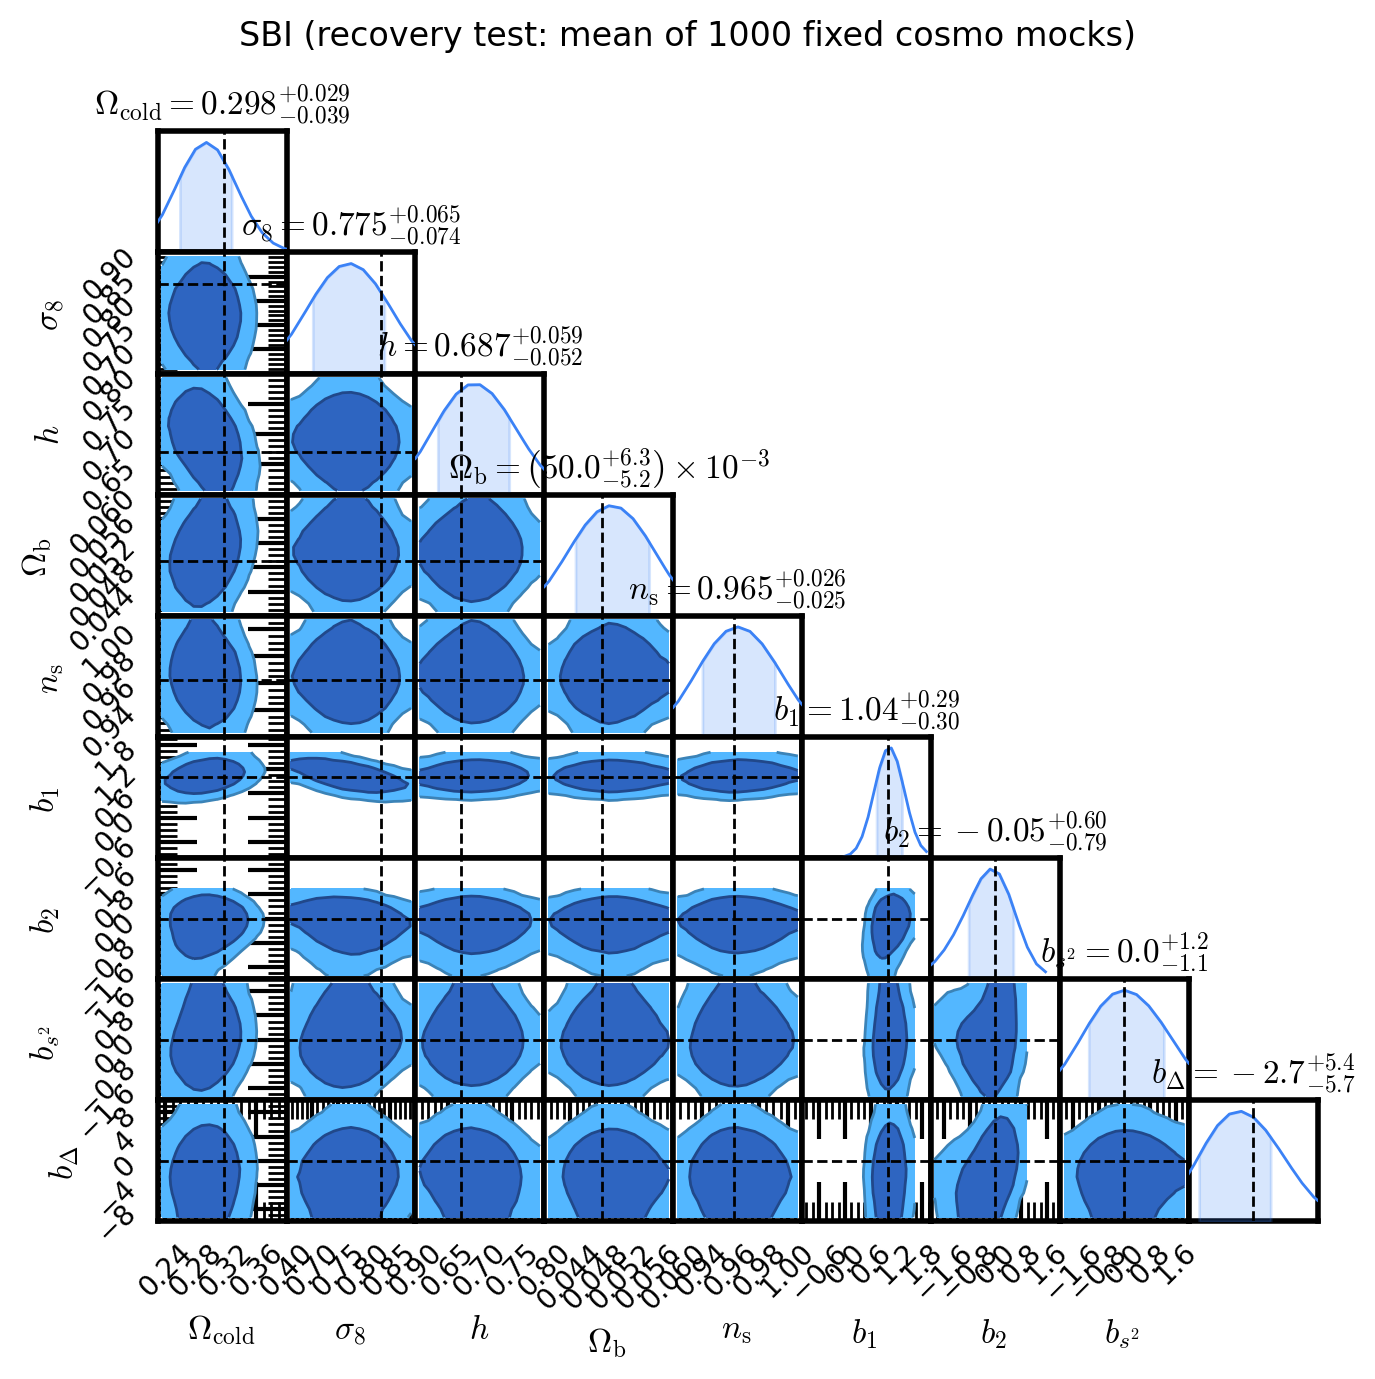

In [38]:
n_train = 10000
tag_params_train = '_p5_n10000'
tag_biasparams_train = '_biaszen_p4_n10000'
tag_biasparams_train_x10 = '_biaszen_p4_n100000'

inf_methods = [
               'sbi',
               #'fisher'
              ]
tags_inf = [
            f'_muchisimocksPk{tag_params_train}{tag_biasparams_train}_ntrain{n_train}_best-sbi-rand10',
            #'_muchisimocks_pk'
            ]
tags_test = [
             #f'{tag_data_test_fixed}_mean',
             '_muchisimocksPk_quijote_p0_n1000_b1000_p0_n1_mean',
             ''
            ]
labels_extra = [
                '',
                '',
                ]
title = 'SBI (recovery test: mean of 1000 fixed cosmo mocks)'
#title = 'SBI'
colors = ['blue', 'gray']

print(tags_inf)
param_names_vary = utils.param_names_all_ordered
idx_obs = 0
plotter.plot_contours_inf(param_names_vary, idx_obs, theta_fid, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels_extra=labels_extra,
                        title=title, extents=extents)

### Add priors

In [41]:

# assume gaussian w width half the extent
sigmas = np.array([(extents[pn][1]-extents[pn][0])/2 for pn in utils.param_names_all_ordered])
cov_inv_priors = np.diag(1/sigmas**2)
fisher_matrix_shift_biaszen_nd1_withpriors = fisher_matrix_shift_biaszen_nd1 + cov_inv_priors

cov_fisher_shift_biaszen_nd1_withpriors = np.linalg.inv(fisher_matrix_shift_biaszen_nd1_withpriors)

In [42]:
n_samples = 10000
samples_shift_biaszen_nd1_withpriors = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_nd1_withpriors, size=n_samples)

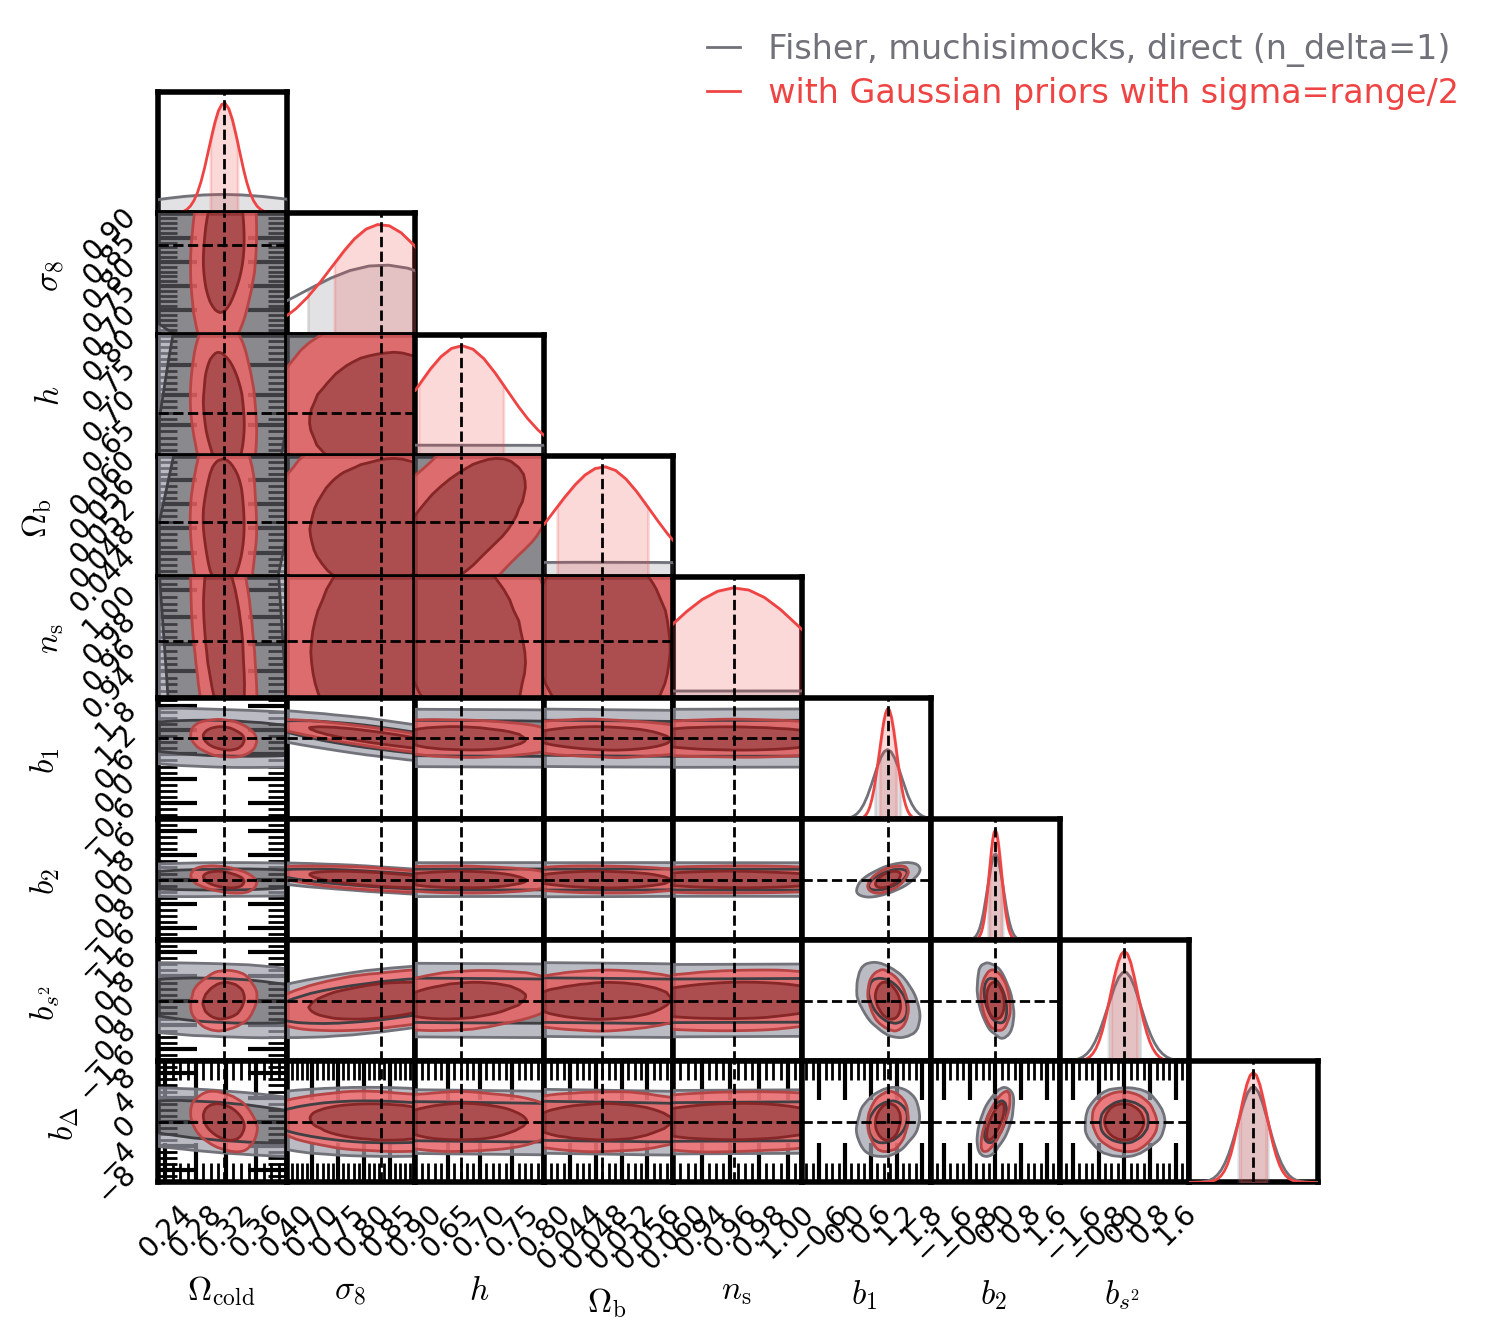

In [43]:

samples_arr = [samples_shift_biaszen_nd1, samples_shift_biaszen_nd1_withpriors]
labels = ['Fisher, muchisimocks, direct (n_delta=1)', 'with Gaussian priors with sigma=range/2']
colors = ['gray', 'red']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

# Bispectrum time!

## Fiducial CV set to get cov

In [44]:
data_mode = 'muchisimocks'
statistics_bispec = ['bispec']

tag_params_cv = '_quijote_p0_n1000'
tag_biasparams_cv = '_b1000_p0_n1'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats_bispec = f'_{"_".join(statistics)}'    
tag_data_bispec = '_'+data_mode + tag_stats_bispec + tag_params_cv + tag_biasparams_cv + tag_datagen

In [45]:
k_cv_bispec, y_cv_bispec, y_err_cv_bispec, idxs_params_cv_bispec, params_df_cv_bispec, param_dict_fixed_cv_bispec, biasparams_df_cv_bispec, biasparams_dict_fixed_cv_bispec, random_ints_cosmo_cv_bispec, random_ints_bias_cv_bispec = \
            data_loader.load_data(data_mode, statistics_bispec, 
                                    tag_params_cv, tag_biasparams_cv,
                                    tag_data=tag_data_bispec,
                                    kwargs=kwargs_data)
k_cv_bispec, y_cv_bispec, y_err_cv_bispec = k_cv_bispec[0], y_cv_bispec[0], y_err_cv_bispec[0]

Loading muchisimocks data
_b1000_p0_n1
Found 1000 bispecs in /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_quijote_p0_n1000_b1000_p0_n1
dir statistics /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_quijote_p0_n1000_b1000_p0_n1
Loaded bispec data with shape (1000, 50)
No mask for this statistic, using all data
Masked 0 out of 50 bins


In [46]:
# this should align with y_cv
param_names_cv = data_loader.get_param_names(tag_params=tag_params_cv, tag_biasparams=tag_biasparams_cv)

In [47]:
params_dict_cv = param_dict_fixed_cv.copy()
params_dict_cv.update(biasparams_dict_fixed_cv)
print(params_dict_cv)

{'omega_cold': 0.3175, 'sigma8_cold': 0.834, 'hubble': 0.6711, 'omega_baryon': 0.049, 'ns': 0.9624, 'neutrino_mass': 0.0, 'w0': -1.0, 'wa': 0.0, 'b1': 1, 'b2': 0, 'bs2': 0, 'bl': 0}


In [52]:
cov_fid_bispec = np.cov(y_cv_bispec, rowvar=False)
print(cov_fid_bispec.shape)

(50, 50)


In [49]:
theta_fid = [params_dict_cv[param] for param in utils.param_names_all_ordered]

In [53]:
corr_fid_bispec = cov_fid_bispec / np.sqrt(np.outer(np.diag(cov_fid_bispec), np.diag(cov_fid_bispec)))

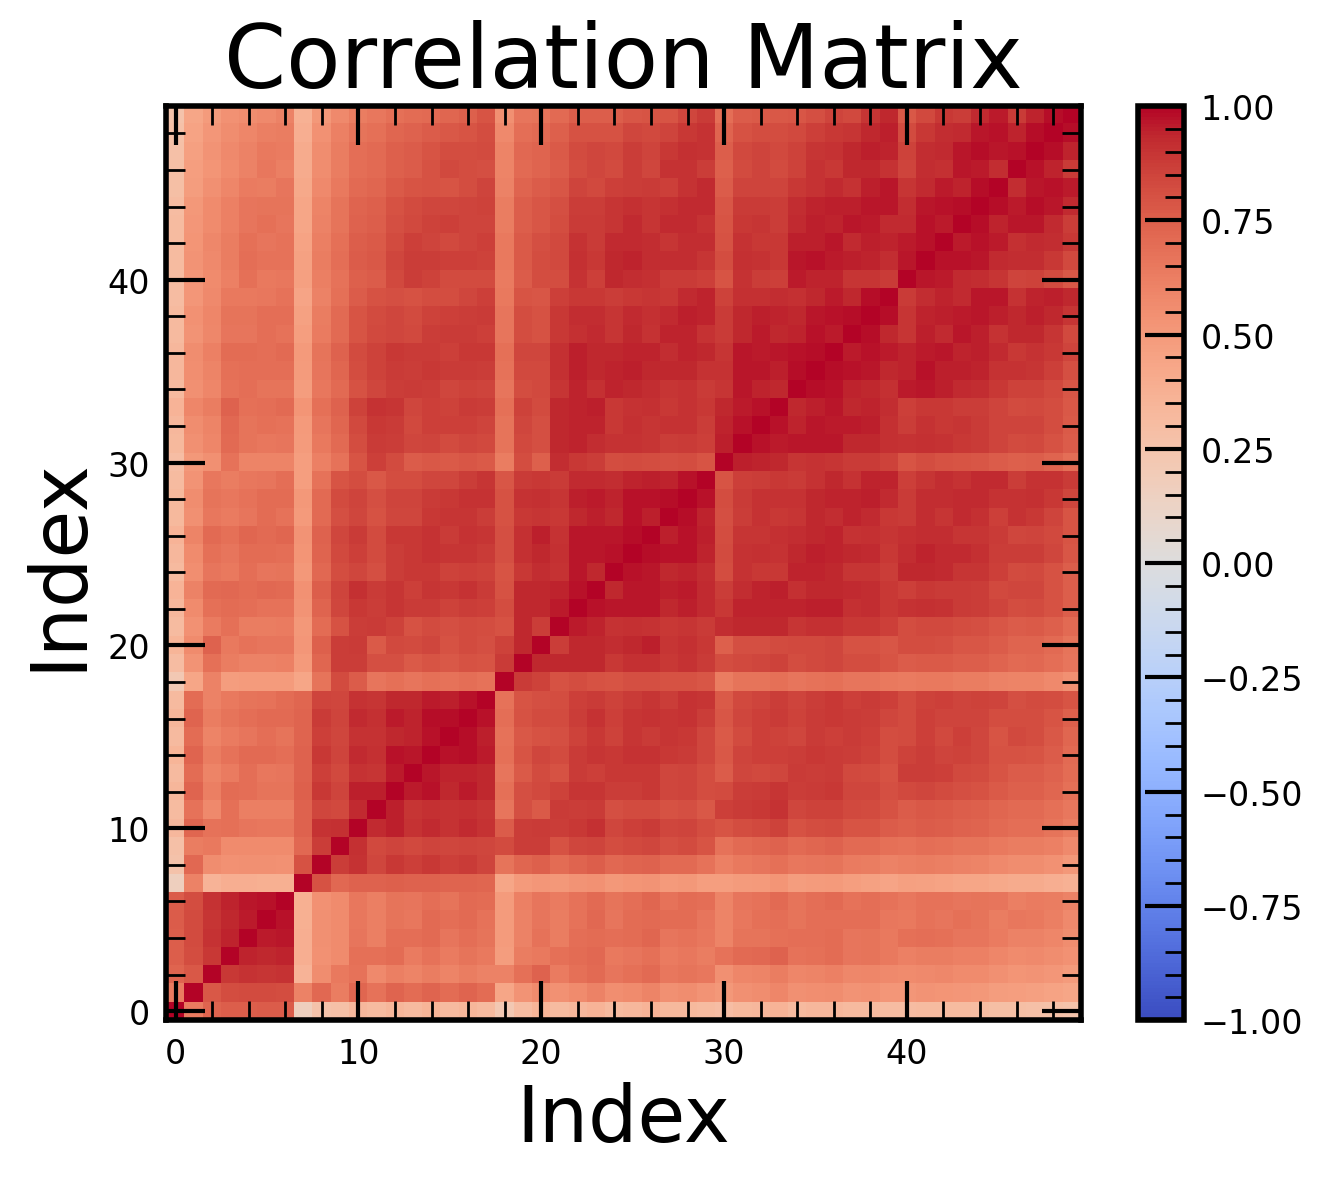

In [54]:
plt.figure(figsize=(8, 6))
im = plt.imshow(corr_fid_bispec, cmap='coolwarm', vmin=-1, vmax=1, aspect='equal', origin='lower')
plt.title('Correlation Matrix')
plt.xlabel('Index')
plt.ylabel('Index')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

## Fisher set to get derivs

In [55]:
data_mode = 'muchisimocks'
statistics_bispec = ['bispec']

tag_params = '_fisher_quijote'
tag_biasparams_biaszen = '_fisher_biaszen'
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats_bispec = f'_{"_".join(statistics_bispec)}'    
tag_data_biaszen_bispec = '_'+data_mode + tag_stats_bispec + tag_params + tag_biasparams_biaszen + tag_datagen

In [78]:
k_biaszen_bispec, y_biaszen_bispec, y_err_biaszen_bispec, idxs_params_biaszen_bispec, params_df_biaszen_bispec, param_dict_fixed_biaszen_bispec, biasparams_df_biaszen_bispec, biasparams_dict_fixed_biaszen_bispec, random_ints_cosmo_biaszen_bispec, random_ints_bias_biaszen_bispec = \
            data_loader.load_data(data_mode, statistics_bispec, 
                                    tag_params, tag_biasparams_biaszen,
                                    tag_data=tag_data_biaszen_bispec,
                                    kwargs=kwargs_data)
k_biaszen_bispec, y_biaszen_bispec, y_err_biaszen_bispec, = k_biaszen_bispec[0], y_biaszen_bispec[0], y_err_biaszen_bispec[0]
print(k_biaszen_bispec.shape)
print(y_biaszen_bispec.shape)

Loading muchisimocks data
Found 21 bispecs in /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_fisher_quijote_fisher_biaszen
Loaded bispec data with shape (37, 50)
No mask for this statistic, using all data
Masked 0 out of 50 bins
(3, 50)
(37, 50)


In [79]:
y_biaszen_bispec_ordered = y_biaszen_bispec[matching_indices]
print(y_biaszen_bispec_ordered.shape)

(37, 50)


### Compute derivs

In [80]:
derivatives_shift_biaszen_bispec_nd1 = compute_derivatives_from_fisherset(params_all_df, 
                                                                   y_biaszen_bispec_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=1)

In [81]:
derivatives_shift_biaszen_bispec_nd2 = compute_derivatives_from_fisherset(params_all_df, 
                                                                   y_biaszen_bispec_ordered, 
                        utils.param_names_all_ordered, n_deltas_for_diff=2)

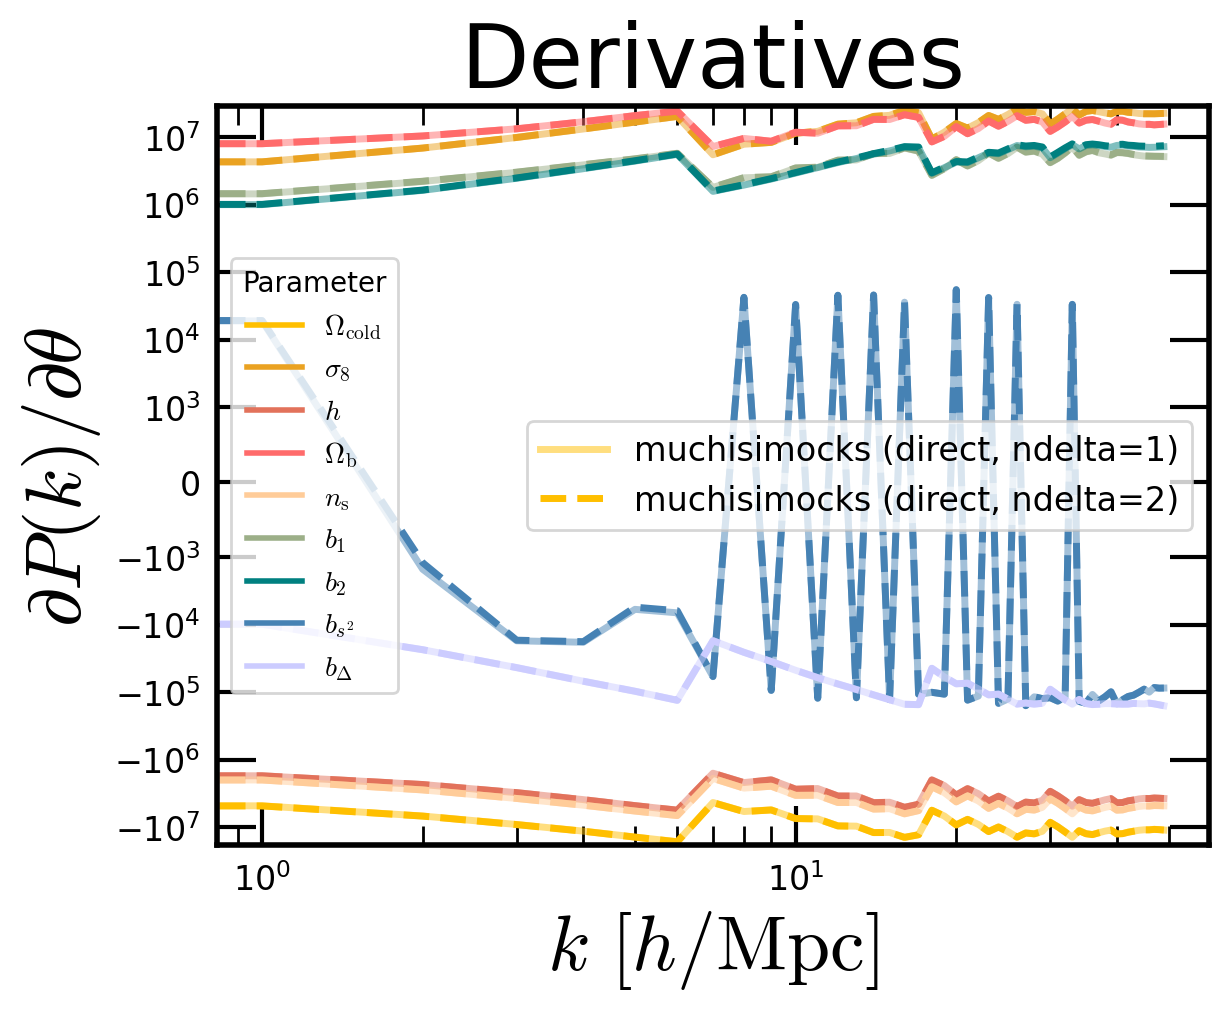

In [82]:
colors_params = ["#FFBF00", "#EAA221", "#E2725B", "#FF6B6B", "#FFCC99", "#9CAF88", "#008080", "#4682B4", "#CCCCFF"]

param_names_show = utils.param_names_all_ordered
for i, param_name in enumerate(param_names_show):
#for i, param_name in enumerate(param_names):
    if i==0:
        label_muchisimocks = 'muchisimocks (direct, ndelta=1)'
        label_muchisimocks2 = 'muchisimocks (direct, ndelta=2)'
    else:
        label_muchisimocks = None
        label_muchisimocks2 = None

    plt.plot(derivatives_shift_biaszen_bispec_nd1[param_name], label=label_muchisimocks, color=colors_params[i], alpha=0.5)
    plt.plot(derivatives_shift_biaszen_bispec_nd2[param_name], label=label_muchisimocks2, color=colors_params[i], ls='--')
    # plt.plot(k_emu, derivatives_emu[param_name], label=label_emuPk, ls='--', lw=1, color=colors_params[i])
    # plt.plot(k_emu, derivatives_emu_shift[param_name], label=label_emuPk_shift, ls=':', color=colors_params[i])
#plt.plot(k_emu, np.sqrt(np.diag(cov_fid_emu)), label='cov_fid_emu', color='red')


# First legend: dataset types
legend1 = plt.legend(fontsize=12, loc='best')
plt.gca().add_artist(legend1)

# Second legend: parameter colors
from matplotlib.lines import Line2D
param_legend_handles = [Line2D([0], [0], color=colors_params[i], lw=2, label=utils.param_label_dict[param_names_show[i]]) for i in range(len(param_names_show))]
plt.legend(handles=param_legend_handles, title='Parameter', loc='best', fontsize=10)

plt.title(f'Derivatives')
plt.xlabel(r'$k\ [h/\mathrm{Mpc}]$')
plt.ylabel(r'$\partial P(k) / \partial \theta$')
plt.xscale('log')
plt.yscale('symlog', linthresh=1e3)

### Compute fisher matrices

In [83]:
fisher_matrix_shift_biaszen_bispec_nd1 = utils.compute_fisher_matrix(derivatives_shift_biaszen_bispec_nd1, cov_fid_bispec, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_bispec_nd1 = np.linalg.inv(fisher_matrix_shift_biaszen_bispec_nd1)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_bispec_nd1.shape)

Fisher matrix shape: (9, 9)


In [84]:
fisher_matrix_shift_biaszen_bispec_nd2 = utils.compute_fisher_matrix(derivatives_shift_biaszen_bispec_nd2, cov_fid_bispec, utils.param_names_all_ordered)
cov_fisher_shift_biaszen_bispec_nd2 = np.linalg.inv(fisher_matrix_shift_biaszen_bispec_nd2)
print("Fisher matrix shape:", fisher_matrix_shift_biaszen_bispec_nd2.shape)

Fisher matrix shape: (9, 9)


In [85]:
n_samples = 10000
samples_shift_biaszen_bispec_nd1 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_bispec_nd1, size=n_samples)

In [86]:
n_samples = 10000
samples_shift_biaszen_bispec_nd2 = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_shift_biaszen_bispec_nd2, size=n_samples)

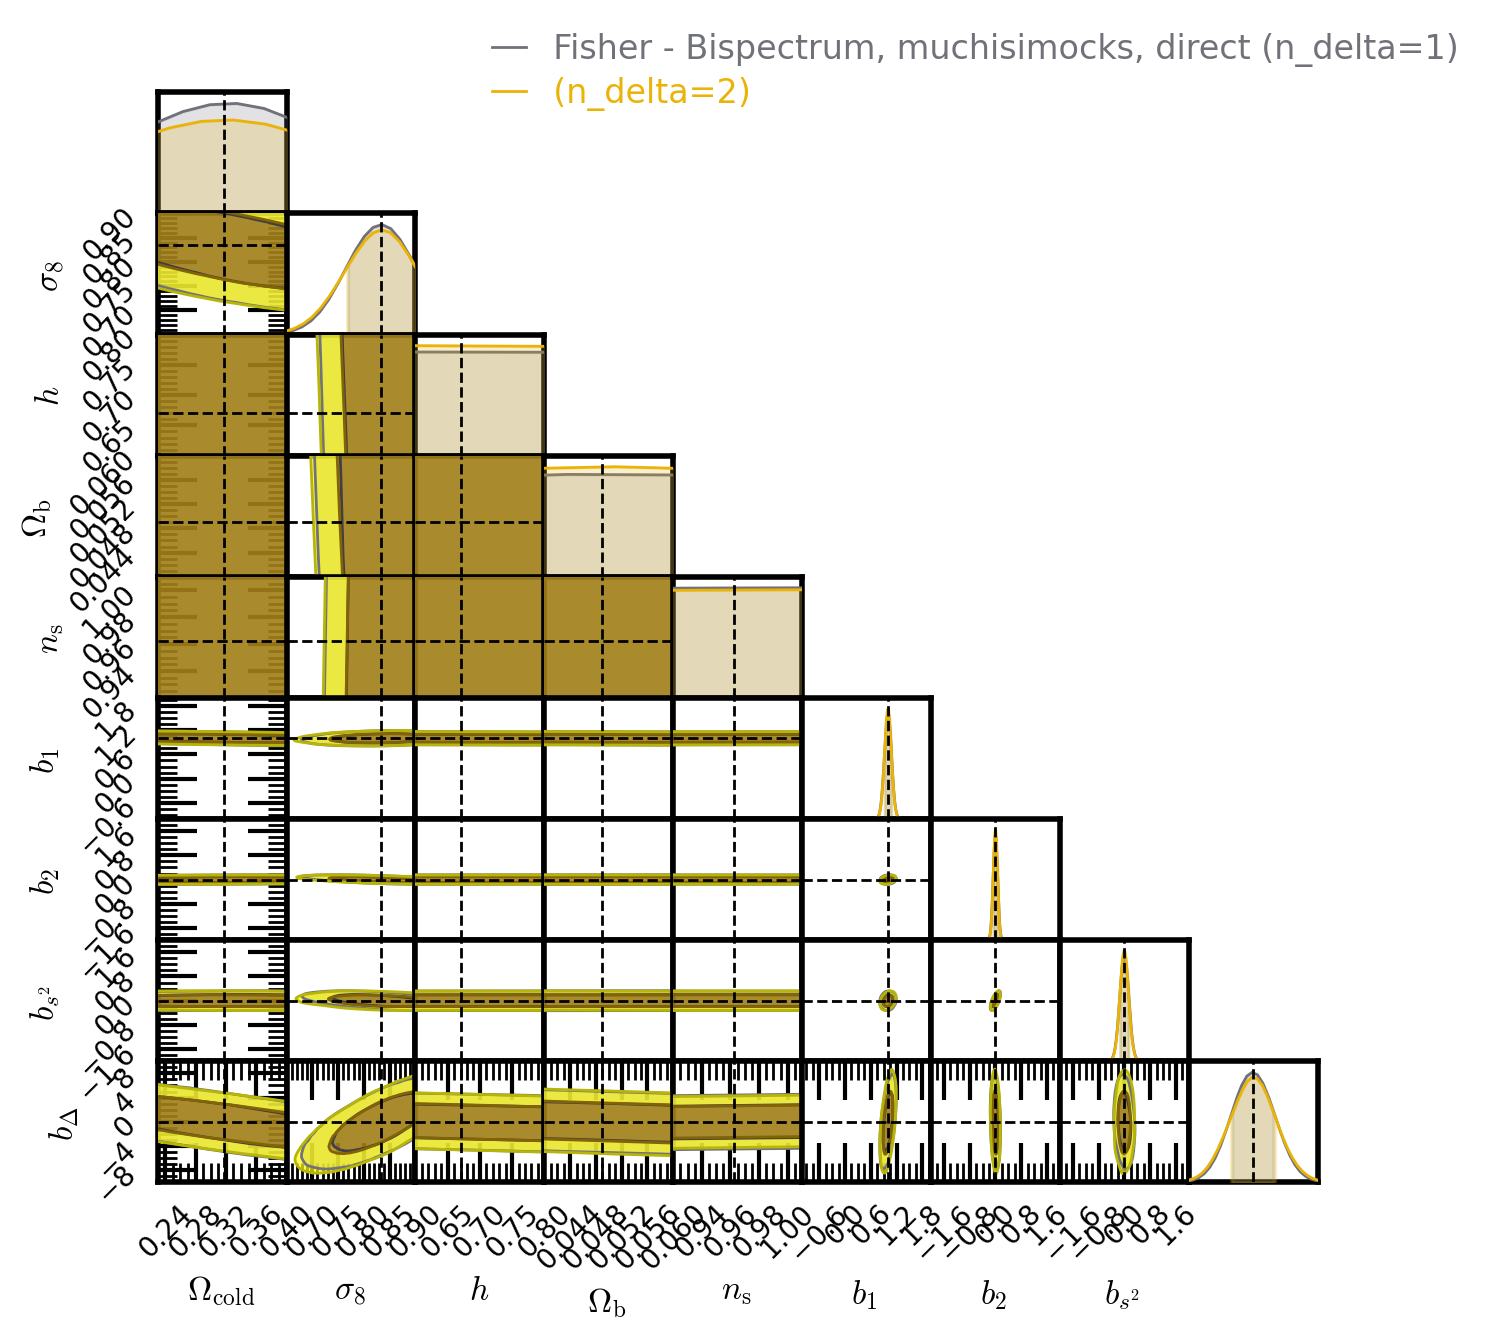

In [87]:

samples_arr = [samples_shift_biaszen_bispec_nd1, samples_shift_biaszen_bispec_nd2]
labels = ['Fisher - Bispectrum, muchisimocks, direct (n_delta=1)', '(n_delta=2)']
colors = ['gray', 'yellow']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=None, extents=extents, 
                  figsize=(7,7), fn_save=None)

## P(k) + bispec

In [93]:
# 1. Stack the data vectors (not strictly needed for Fisher, but for completeness)
y_cv_combined = np.concatenate([y_cv, y_cv_bispec], axis=1)  # shape: N x (D+D_bispec)

# 2. Build the block-diagonal covariance matrix
from scipy.linalg import block_diag

cov_combined = block_diag(cov_fid, cov_fid_bispec)  # shape: (D+D_bispec, D+D_bispec)

# 3. Concatenate the derivatives for each parameter
derivatives_combined = {}
for param in utils.param_names_all_ordered:
    deriv_pk = derivatives_shift_biaszen_nd1[param]           # shape: D
    deriv_bispec = derivatives_shift_biaszen_bispec_nd1[param] # shape: D_bispec
    derivatives_combined[param] = np.concatenate([deriv_pk, deriv_bispec])

print(len(derivatives_combined['omega_cold']))

fisher_matrix_combined = utils.compute_fisher_matrix(derivatives_combined, cov_combined, utils.param_names_all_ordered)
cov_fisher_combined = np.linalg.inv(fisher_matrix_combined)

print("Combined Fisher matrix shape:", fisher_matrix_combined.shape)

79
Combined Fisher matrix shape: (9, 9)


In [96]:
n_samples = 10000
samples_shift_combined = np.random.multivariate_normal(theta_fid[:len(utils.param_names_all_ordered)], cov_fisher_combined, size=n_samples)

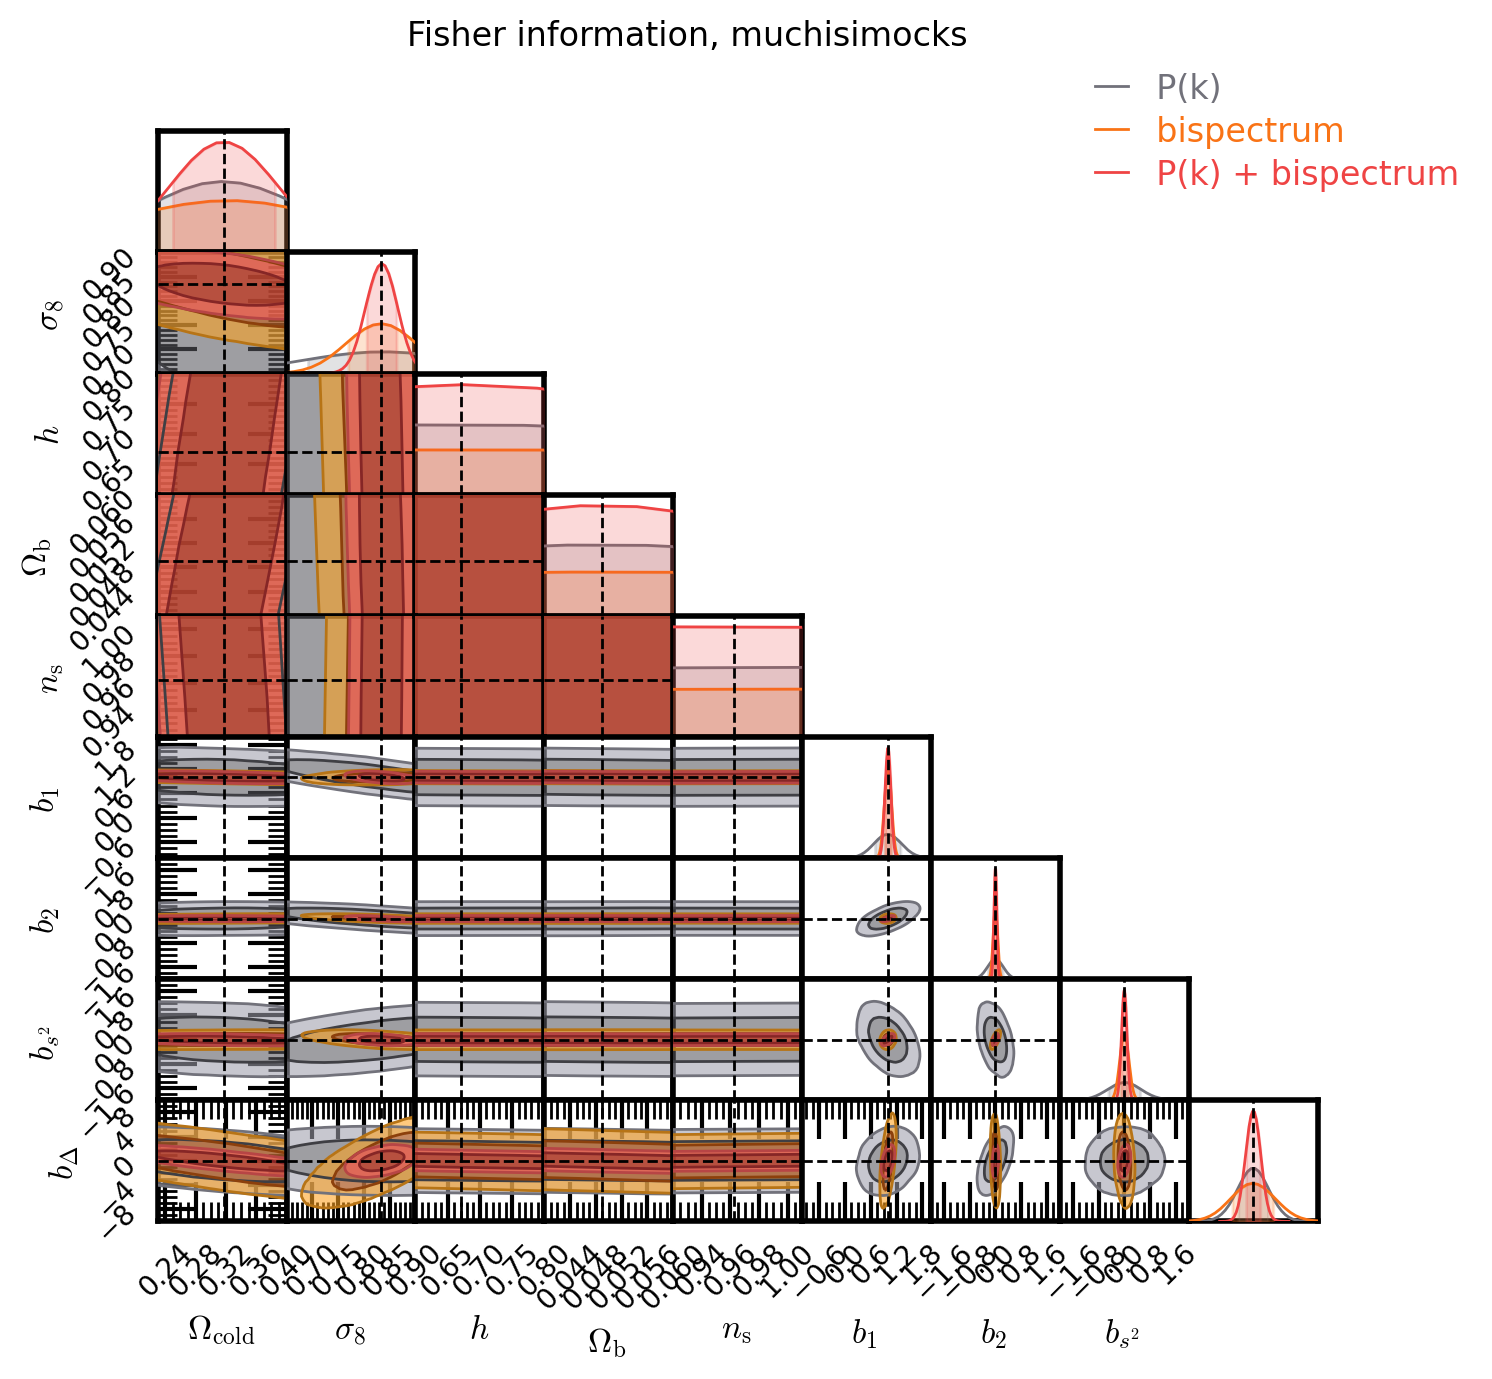

In [99]:

samples_arr = [samples_shift_biaszen_nd1, samples_shift_biaszen_bispec_nd1, samples_shift_combined]
labels = ['P(k)',
          'bispectrum',
          'P(k) + bispectrum']
colors = ['gray', 'orange', 'red']
smooth_arr = [2]*len(samples_arr)
bins_arr = [10]*len(samples_arr)
title = 'Fisher information, muchisimocks'
plotter.plot_contours(samples_arr, labels, colors, utils.param_names_all_ordered, 
                      utils.param_label_dict, 
                  smooth_arr=smooth_arr, bins_arr=bins_arr,
                  truth_loc=params_dict_cv, title=title, extents=extents, 
                  figsize=(7,7), fn_save=None)